## PSO compression search on LeNet-5 

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController, Particle
from utils.plot import *
from utils.fitness_controller import FitnessController

Setting parameters

In [3]:
# net train settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

# net save settings
NET_PATH = '../models/lenet/saves/lenet_relu.save'
NET_TYPE = 'relu'

# pso iter count
NUM_ITERATIONS = 5 #20
NUM_PARTICLES = 20

# pso search settings
PARTICLE_REPR_RANGES = [range(1, 51) for _ in range(5)]
PARTICLE_MAX_VELOCITY = [4 for _ in range(5)]
INERTIA = 0.8

# pso save settings
SAVE_PSO_FILE = '../results/test_PSO_save.csv'
SAVE_EVERY = 1

# range optimization settings
RANGE_OPTIMIZATION = True
RANGE_OPTIMIZATION_TRESHOLD = 0.97
RANGE_OPTIMIZATION_FILE = '../results/lenet-relu-layer-perf.csv'

# target position
TARGET = [1.0, 1.0]
LOCK_TARGET = False

# WS settings
SHARE_ORDER = [0, 1, 2, 3, 4]
RETRAIN_AMOUNT = None #[0, 0, 0, 0, 0]
PREC_REDUCT = None #['f4', 'f4', 'f4', 'f4', 'f4']
CLUST_MOD_FOCUS = None #[0, 0, 0, 0, 0]
CLUST_MOD_SPREAD = None #[0, 0, 0, 0, 0]

Geting somewhat trained LeNet-5

In [4]:
dataset = MnistDataset(BATCH_SIZE, '../data', val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings, DEVICE)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [5]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.set_reset()

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [6]:
def fitness_vals_fc(individual:Particle):
    # reset the net
    ws_controller.reset()
    
    # share weigts by particle
    if individual.data is None:
        individual.data = ws_controller.share(individual.representation, SHARE_ORDER, RETRAIN_AMOUNT, PREC_REDUCT, CLUST_MOD_FOCUS, CLUST_MOD_SPREAD)
    
    return [individual.data['accuracy'], individual.data['compression']]

def fit_from_vals(fit_vals, targ_vals, individual:Particle = None):

    result = None

    # compute fitness
    if fit_vals[0] <= 0.95:
        result = fit_vals[0]

    else:
        result = 1 / math.sqrt(pow(1 - ((fit_vals[0] - 0.9) * (1/0.1)), 2) + pow(1 - (fit_vals[1]/targ_vals[1]), 2))

    if individual is not None:
        individual.fitness = result
        
        if individual.my_best is not None:
            #bevare of recursion
            individual.my_best.fitness = fit_from_vals([individual.my_best.data['accuracy'], individual.my_best.data['compression']], targ_vals)

        if individual.my_best is None or individual.fitness > individual.my_best.fitness:
            individual.my_best = copy.deepcopy(individual)
            individual.my_best.my_best = None

    
    return result

Define logging function

In [7]:
data = {
    'time': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Optimizing ranges

In [8]:
lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    PARTICLE_REPR_RANGES = ws_controller.get_optimized_layer_ranges(PARTICLE_REPR_RANGES, lam_test_inp, RANGE_OPTIMIZATION_TRESHOLD, 
        savefile=RANGE_OPTIMIZATION_FILE)

for repr_range in PARTICLE_REPR_RANGES:
    print(len(repr_range))

49
47
47
48
47


Running the search

In [9]:
fit_controll = FitnessController(TARGET, fitness_vals_fc, fit_from_vals,target_max_offset=1, lock=LOCK_TARGET)
pso = PSOController(NUM_PARTICLES, PARTICLE_REPR_RANGES, PARTICLE_MAX_VELOCITY, INERTIA, fit_controll)

if pso_data.size != 0:
    pso.load_from_pd(pso_data, verbose=True)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Fitness target update to [ 1.         12.22670174]
Time 0/5 (4) best fitness 3
Time 1/5 (5) best fitness 3.2482022128773327
Time 2/5 (6) best fitness 3.338664605613689
Time 3/5 (7) best fitness 3.338664605613689
Time 4/5 (8) best fitness 3.338664605613689
Time 5/5 (9) best fitness 3.338664605613689


[2, 19, 6, 24, 42]

In [10]:
pso_data

,time,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t,fitness
0,0,"[8.929187883995425, 9.569965853636491, 1.73484...","[26, 24, 21, 36, 13]","[-4, -1.0994333911615353, -4, -4, 4]",0.9862,-0.0016,5.475885,1.495821,0.0,4.025360,1.0
1,0,"[15.883698746438208, 17.308664088588046, 2.633...","[28, 5, 17, 39, 49]","[1.4553140014329158, 4, -4, 1.086525204562854, 4]",0.9780,0.0066,5.716939,1.218210,0.0,4.101524,1.0
2,0,"[0, 12.26123537936811, 0, 21.971657600991463, ...","[8, 28, 16, 25, 39]","[-3.2, -3.2, -3.041480919753103, -2.6142288732...",0.9838,0.0008,6.169777,1.074853,0.0,4.022613,1.0
3,0,"[28.405643010820654, 24.52201387721951, 20.504...","[38, 28, 40, 12, 30]","[4, 4, -4, -1.993161573694048, -4]",0.9846,0.0000,5.244367,1.636168,0.0,3.938540,1.0
4,0,"[7.041171074353617, 9.654897820467486, 17.1671...","[21, 7, 29, 11, 20]","[-4, 4, -4, -4, 4]",0.9838,0.0008,6.638814,1.351341,0.0,4.149736,2.0
...,...,...,...,...,...,...,...,...,...,...,...
195,9,"[0, 18.575002929160505, 0.20360420304680105, 2...","[2, 22, 4, 23, 45]","[-2.0480000000000005, 3.7878297412467608, -4, ...",0.9674,0.0172,10.893797,0.566605,0.0,3.362878,NaN
196,9,"[18.883107723680446, 14.653947632249636, 0, 18...","[20, 18, 4, 21, 43]","[0.696433008015882, -4, -2.4624221477777413, -...",0.9792,0.0054,7.118544,0.612543,0.0,3.842866,NaN
197,9,"[0, 13.047708303446788, 0.20361945733380127, 2...","[2, 17, 4, 24, 42]","[-0.8053866021504087, -1.2538191032356019, -2....",0.9646,0.0200,10.924130,0.561121,0.0,3.406337,NaN
198,9,"[0, 14.022910709112317, 1.466153660313961, 22....","[2, 18, 5, 25, 42]","[-1.0485760000000004, -0.5010864851292397, -1....",0.9728,0.0118,9.854941,0.642932,0.0,3.585722,NaN


Text(0.5, 1.0, 'PSO algorithm on LeNet-5')

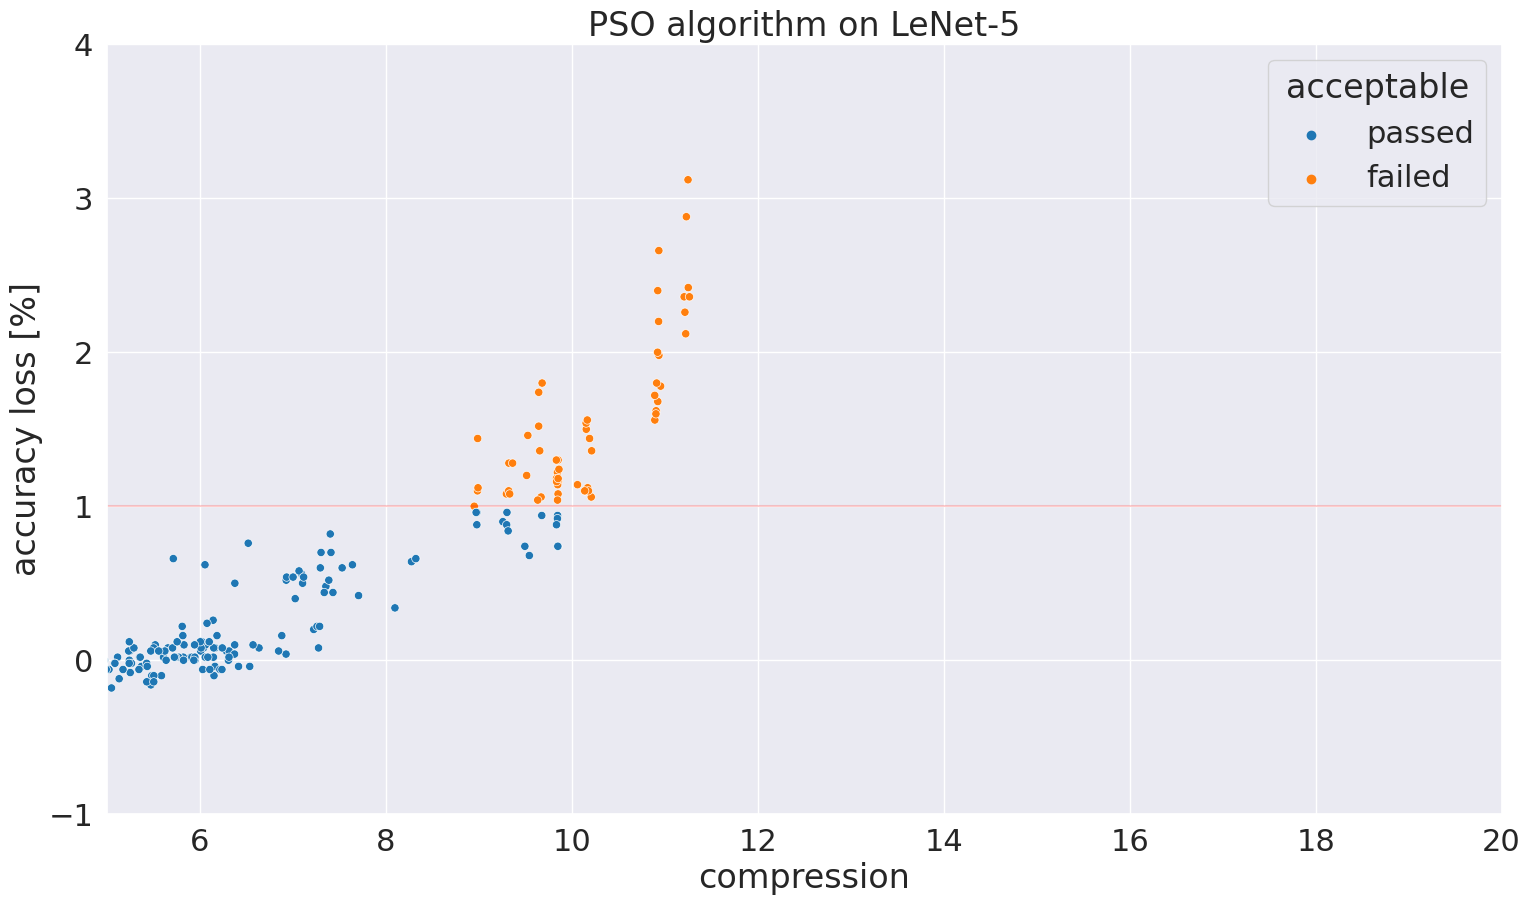

In [11]:
plot_alcr(pso_data)
plt.title('PSO algorithm on LeNet-5')